In [1]:
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

%matplotlib inline
sns.set(style="darkgrid")
pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv('./Datasets/train.csv')

In [3]:
import random

test_index_1 = random.sample(list(train[train.Class==1].index), int(15*train[train.Class==1].shape[0]/100))
test_index_0 = random.sample(list(train[train.Class==0].index), int(15*train[train.Class==0].shape[0]/100))

test = train.iloc[test_index_1+test_index_0]
train.drop(test_index_1+test_index_0, inplace=True)

In [4]:
train.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
2,1.00,-1.36,-1.34,1.77,0.38,-0.50,1.80,0.79,0.25,-1.51,...,0.25,0.77,0.91,-0.69,-0.33,-0.14,-0.06,-0.06,378.66,0
3,1.00,-0.97,-0.19,1.79,-0.86,-0.01,1.25,0.24,0.38,-1.39,...,-0.11,0.01,-0.19,-1.18,0.65,-0.22,0.06,0.06,123.50,0
7,7.00,-0.64,1.42,1.07,-0.49,0.95,0.43,1.12,-3.81,0.62,...,1.94,-1.02,0.06,-0.65,-0.42,-0.05,-1.21,-1.09,40.80,0
8,7.00,-0.89,0.29,-0.11,-0.27,2.67,3.72,0.37,0.85,-0.39,...,-0.07,-0.27,-0.20,1.01,0.37,-0.38,0.01,0.14,93.20,0
9,9.00,-0.34,1.12,1.04,-0.22,0.50,-0.25,0.65,0.07,-0.74,...,-0.25,-0.63,-0.12,-0.39,-0.07,0.09,0.25,0.08,3.68,0


In [5]:
train.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,242087.00,242087.00,242087.00,242087.00,242087.00,242087.00,242087.00,242087.00,242087.00,242087.00,...,242087.00,242087.00,242087.00,242087.00,242087.00,242087.00,242087.00,242087.00,242087.00,242087.00
mean,94809.42,0.00,0.00,0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00,...,-0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,88.23,0.00
std,47495.84,1.95,1.64,1.51,1.42,1.38,1.33,1.24,1.20,1.10,...,0.73,0.73,0.62,0.61,0.52,0.48,0.40,0.33,252.19,0.04
min,1.00,-56.41,-72.72,-48.33,-5.68,-113.74,-26.16,-43.56,-73.22,-13.43,...,-34.83,-10.93,-44.81,-2.84,-10.30,-2.60,-9.85,-15.43,0.00,0.00
25%,54237.00,-0.92,-0.60,-0.89,-0.85,-0.69,-0.77,-0.55,-0.21,-0.64,...,-0.23,-0.54,-0.16,-0.36,-0.32,-0.33,-0.07,-0.05,5.67,0.00
50%,84645.00,0.02,0.07,0.18,-0.02,-0.05,-0.27,0.04,0.02,-0.05,...,-0.03,0.01,-0.01,0.04,0.02,-0.05,0.00,0.01,22.00,0.00
75%,139303.00,1.32,0.80,1.03,0.74,0.61,0.40,0.57,0.33,0.60,...,0.19,0.53,0.15,0.44,0.35,0.24,0.09,0.08,77.00,0.00
max,172788.00,2.45,22.06,4.23,16.88,34.80,73.30,120.59,20.01,10.39,...,27.20,10.50,22.53,4.58,7.52,3.52,31.61,33.85,25691.16,1.00


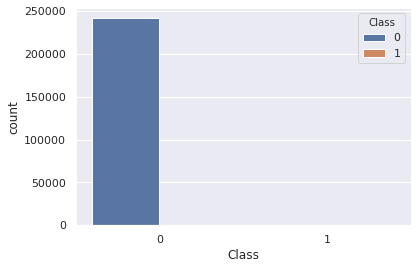

In [6]:
sns.countplot(x='Class', data=train, hue="Class")
plt.show()

In [7]:
print(f"Fraud instaces: {train[train['Class']==1].shape[0]}")
print(f"Non Fraud instaces: {train[train['Class']==0].shape[0]}")
print(f"Fraud percentage: {train[train['Class']==1].shape[0]/train.shape[0]}")
print(f"Non Fraud percentage: {train[train['Class']==0].shape[0]/train.shape[0]}")

Fraud instaces: 419
Non Fraud instaces: 241668
Fraud percentage: 0.001730782735132411
Non Fraud percentage: 0.9982692172648676


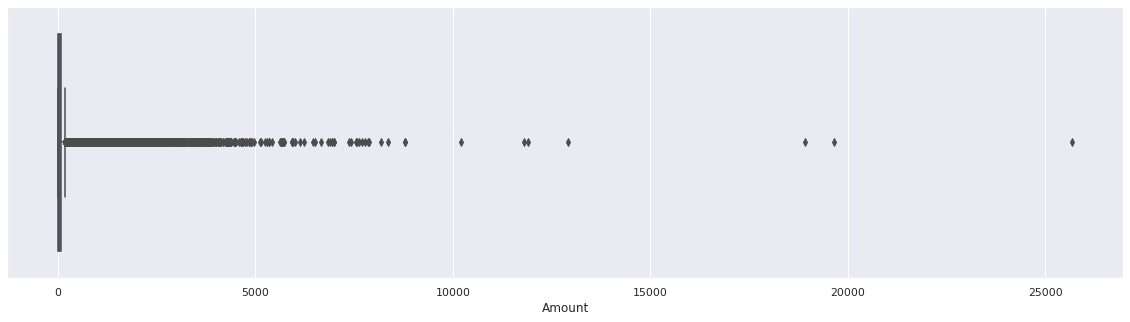

In [8]:
plt.figure(figsize=(20, 5))
sns.boxplot(x=train.Amount)

In [9]:
train = train[train['Amount']  <= 10000]

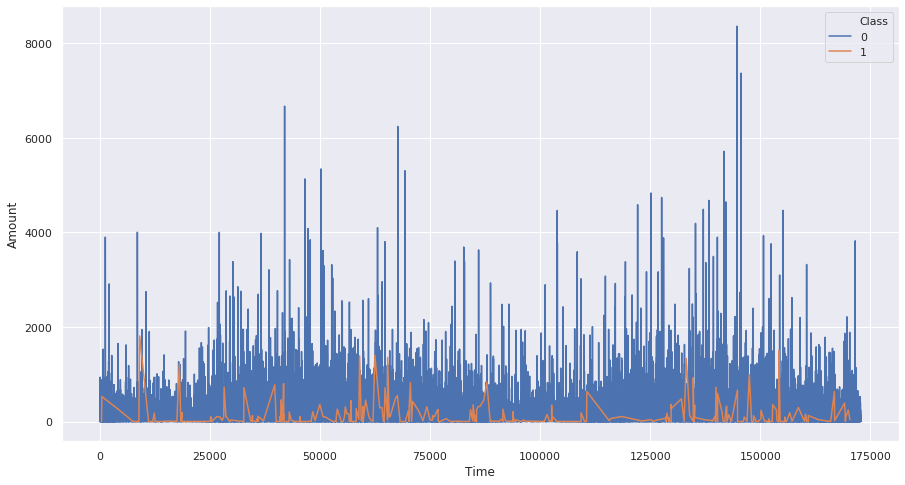

In [10]:
plt.figure(figsize=(15, 8))
sns.lineplot(x="Time", y="Amount", hue="Class", data=train, ci=None)
plt.show()

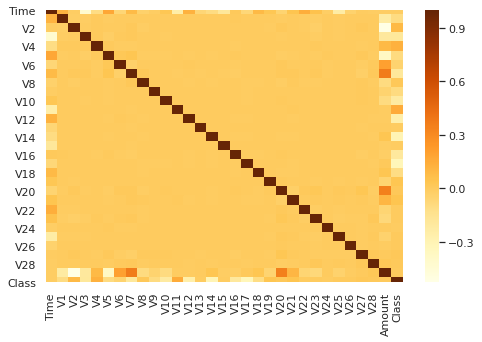

In [11]:
plt.figure(figsize=(8, 5))
sns.heatmap(data = train.corr(), cmap = "YlOrBr")

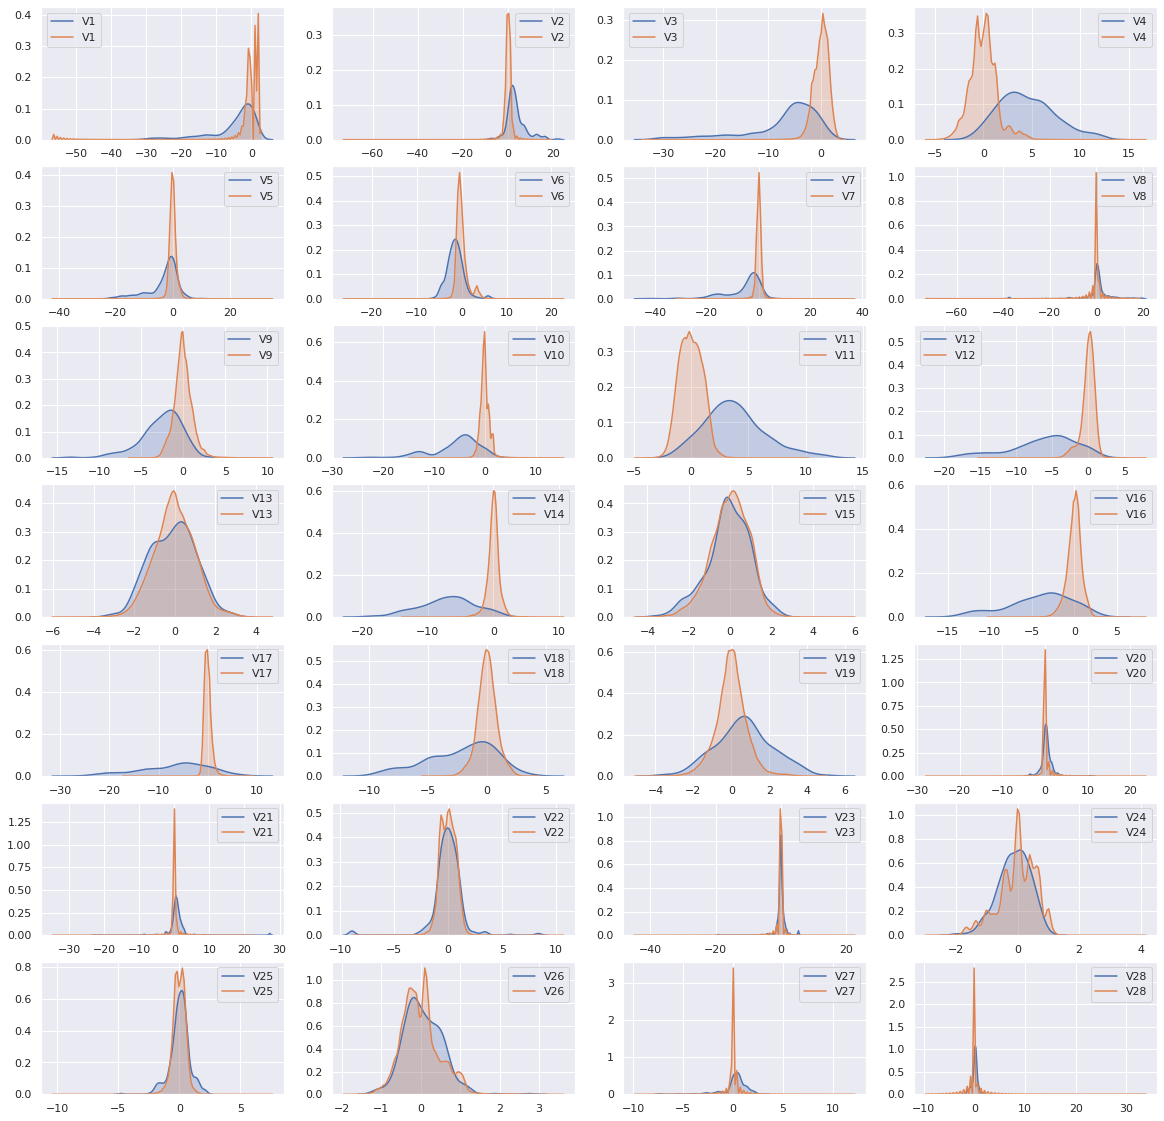

In [12]:
fig, ax = plt.subplots(7, 4, figsize=(20, 20))
for i in range(0, 28):
    sns.kdeplot(train[train['Class']==1][f'V{i+1}'], shade=True, ax=ax[int(i/4)][i%4])
    sns.kdeplot(train[train['Class']==0][f'V{i+1}'], shade=True, ax=ax[int(i/4)][i%4])
fig.show()

In [13]:
train.drop(['V13', 'V15', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28'], axis=1, inplace=True)
test.drop(['V13', 'V15', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28'], axis=1, inplace=True)

In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(train.drop('Class', axis=1))

test_y = test.Class
test = test.drop('Class', axis=1)
test = scaler.transform(test)

class_0_train_1000 = train[train.Class==0].sample(1000)

In [15]:
reduced_data = class_0_train_1000
reduced_data = pd.concat([reduced_data, train[train.Class==1]], ignore_index=True)
reduced_data = reduced_data.sample(frac=1).reset_index(drop=True)

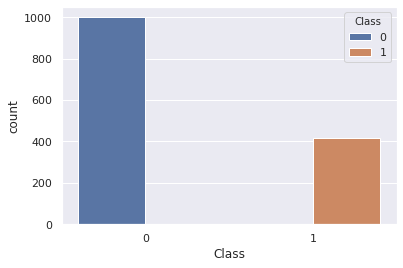

In [16]:
sns.countplot(x='Class', data=reduced_data, hue="Class")

In [17]:
reduced_data_std = scaler.transform(reduced_data.drop('Class', axis=1))
reduced_data_std = pd.DataFrame(reduced_data_std)
reduced_data_std['Class'] = reduced_data.Class
reduced_data_std.columns = reduced_data.columns

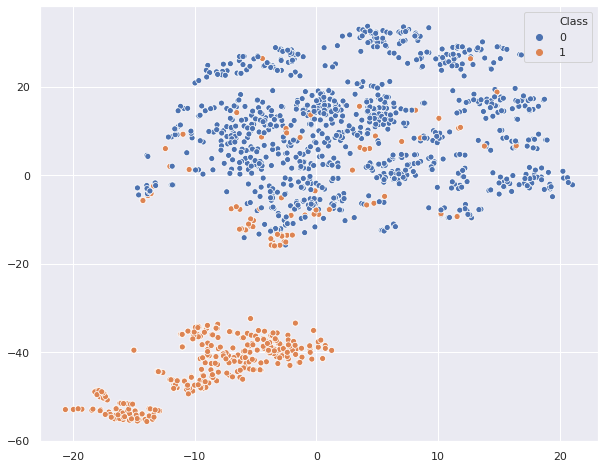

In [18]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0, perplexity=75).fit_transform(reduced_data_std)
plt.figure(figsize=(10,8))
sns.scatterplot(x=tsne[:,0], y=tsne[:,1], hue=reduced_data_std.Class)

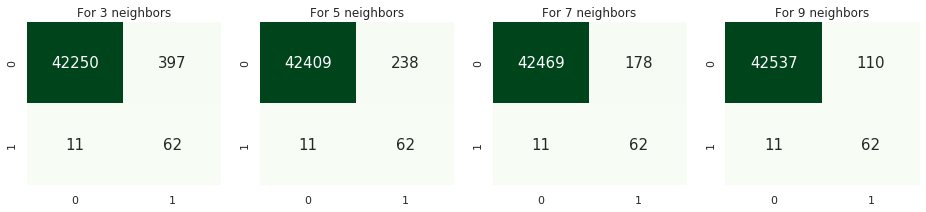

In [19]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

fig, ax = plt.subplots(1, 4, figsize=(16, 3))
i = 0
for n in range(3, 10, 2):
    knn = KNeighborsClassifier(n).fit(reduced_data_std.drop(['Class'], axis=1).values, reduced_data_std.Class.values)
    y_pred = knn.predict(test)    
    sns.heatmap(confusion_matrix(test_y, y_pred), annot=True, ax=ax[i], cmap="Greens", cbar = False, fmt='.0f', annot_kws={"fontsize":15})
    bottom, top = ax[i].get_ylim()
    ax[i].set_ylim(bottom + 0.5, top - 0.5)
    ax[i].title.set_text(f'For {n} neighbors')
    i+=1

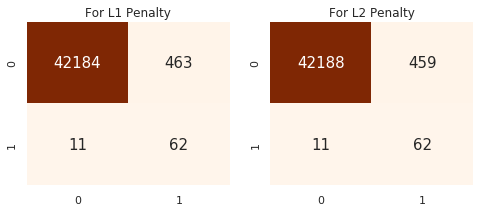

In [20]:
from sklearn.linear_model import LogisticRegression

fig, ax = plt.subplots(1, 2, figsize=(8, 3))

lg = LogisticRegression(penalty='l1', solver='liblinear')\
    .fit(reduced_data_std.drop(['Class'], axis=1).values, reduced_data_std.Class.values)
y_pred = lg.predict(test)
sns.heatmap(confusion_matrix(test_y, y_pred), annot=True, ax=ax[0], cmap="Oranges", cbar = False, fmt='.0f', annot_kws={"fontsize":15})
bottom, top = ax[0].get_ylim()
ax[0].set_ylim(bottom + 0.5, top - 0.5)
ax[0].title.set_text(f'For L1 Penalty')

lg = LogisticRegression(penalty='l2', solver='liblinear')\
    .fit(reduced_data_std.drop(['Class'], axis=1).values, reduced_data_std.Class.values)
y_pred = lg.predict(test)
sns.heatmap(confusion_matrix(test_y, y_pred), annot=True, ax=ax[1], cmap="Oranges", cbar = False, fmt='.0f', annot_kws={"fontsize":15})
bottom, top = ax[1].get_ylim()
ax[1].set_ylim(bottom + 0.5, top - 0.5)
ax[1].title.set_text(f'For L2 Penalty')

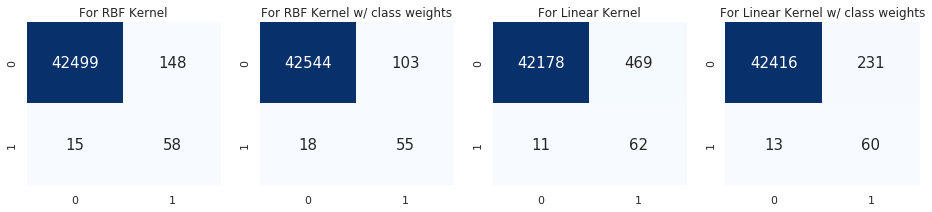

In [21]:
from sklearn.svm import SVC

fig, ax = plt.subplots(1, 4, figsize=(16, 3))

svm = SVC(kernel='rbf')\
    .fit(reduced_data_std.drop(['Class'], axis=1).values, reduced_data_std.Class.values)
y_pred = svm.predict(test)
sns.heatmap(confusion_matrix(test_y, y_pred), annot=True, ax=ax[0], cmap="Blues", cbar = False, fmt='.0f', annot_kws={"fontsize":15})
bottom, top = ax[0].get_ylim()
ax[0].set_ylim(bottom + 0.5, top - 0.5)
ax[0].title.set_text(f'For RBF Kernel')

svm = SVC(kernel='rbf', class_weight={0:0.70, 1:0.30})\
    .fit(reduced_data_std.drop(['Class'], axis=1).values, reduced_data_std.Class.values)
y_pred = svm.predict(test)
sns.heatmap(confusion_matrix(test_y, y_pred), annot=True, ax=ax[1], cmap="Blues", cbar = False, fmt='.0f', annot_kws={"fontsize":15})
bottom, top = ax[1].get_ylim()
ax[1].set_ylim(bottom + 0.5, top - 0.5)
ax[1].title.set_text(f'For RBF Kernel w/ class weights')

svm = SVC(kernel='linear')\
    .fit(reduced_data_std.drop(['Class'], axis=1).values, reduced_data_std.Class.values)
y_pred = svm.predict(test)
sns.heatmap(confusion_matrix(test_y, y_pred), annot=True, ax=ax[2], cmap="Blues", cbar = False, fmt='.0f', annot_kws={"fontsize":15})
bottom, top = ax[2].get_ylim()
ax[2].set_ylim(bottom + 0.5, top - 0.5)
ax[2].title.set_text(f'For Linear Kernel')

svm = SVC(kernel='linear', class_weight={0:0.60, 1:0.40})\
    .fit(reduced_data_std.drop(['Class'], axis=1).values, reduced_data_std.Class.values)
y_pred = svm.predict(test)
sns.heatmap(confusion_matrix(test_y, y_pred), annot=True, ax=ax[3], cmap="Blues", cbar = False, fmt='.0f', annot_kws={"fontsize":15})
bottom, top = ax[3].get_ylim()
ax[3].set_ylim(bottom + 0.5, top - 0.5)
ax[3].title.set_text(f'For Linear Kernel w/ class weights')

In [22]:
from imblearn.over_sampling import SMOTE

sampled_data = class_0_train_1000
sampled_data = pd.concat([sampled_data, train[train.Class==1]], ignore_index=True)
sampled_data = sampled_data.sample(frac=1).reset_index(drop=True)

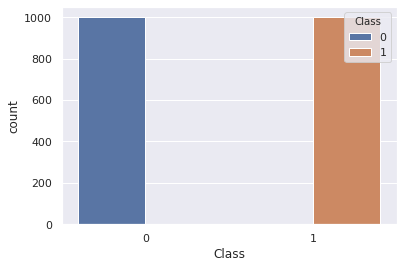

In [23]:
oversampled_data, oversampled_y = SMOTE(k_neighbors=7).fit_resample(sampled_data.drop('Class', axis=1), sampled_data.Class)
oversampled_data['Class'] =  oversampled_y
sns.countplot(x='Class', data=oversampled_data, hue="Class")

In [24]:
oversampled_data_std = scaler.transform(oversampled_data.drop('Class', axis=1))
oversampled_data_std = pd.DataFrame(oversampled_data_std)
oversampled_data_std['Class'] = oversampled_data.Class
oversampled_data_std.columns = oversampled_data_std.columns

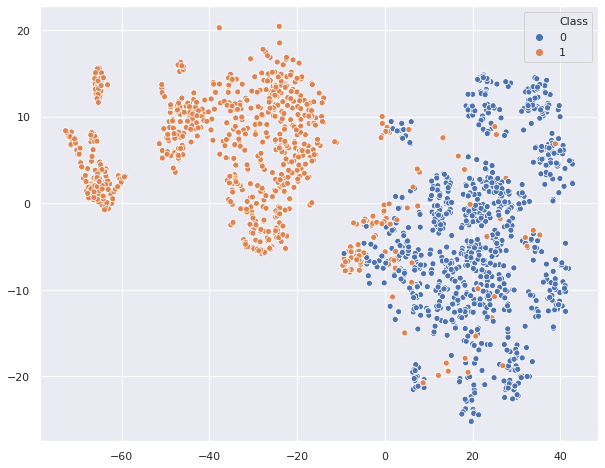

In [25]:
tsne = TSNE(n_components=2, random_state=0, perplexity=75).fit_transform(oversampled_data_std)
plt.figure(figsize=(10,8))
sns.scatterplot(x=tsne[:,0], y=tsne[:,1], hue=oversampled_data_std.Class)

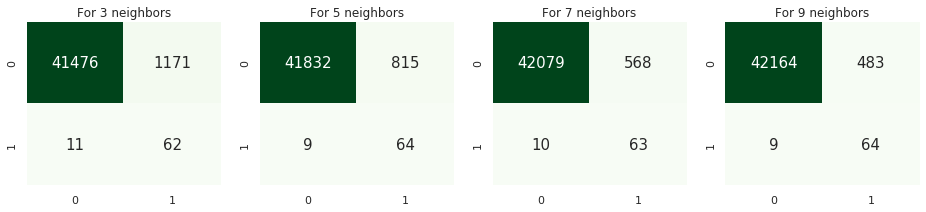

In [26]:
fig, ax = plt.subplots(1, 4, figsize=(16, 3))
i = 0
for n in range(3, 10, 2):
    knn = KNeighborsClassifier(n).fit(oversampled_data_std.drop(['Class'], axis=1).values, oversampled_data_std.Class.values)
    y_pred = knn.predict(test)    
    sns.heatmap(confusion_matrix(test_y, y_pred), annot=True, ax=ax[i], cmap="Greens", cbar = False, fmt='.0f', annot_kws={"fontsize":15})
    bottom, top = ax[i].get_ylim()
    ax[i].set_ylim(bottom + 0.5, top - 0.5)
    ax[i].title.set_text(f'For {n} neighbors')
    i+=1

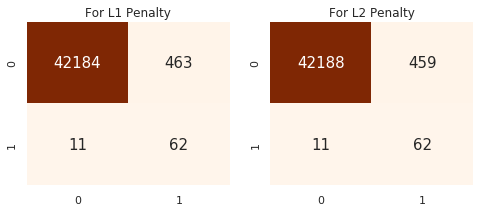

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))

lg = LogisticRegression(penalty='l1', solver='liblinear')\
    .fit(reduced_data_std.drop(['Class'], axis=1).values, reduced_data_std.Class.values)
y_pred = lg.predict(test)
sns.heatmap(confusion_matrix(test_y, y_pred), annot=True, ax=ax[0], cmap="Oranges", cbar = False, fmt='.0f', annot_kws={"fontsize":15})
bottom, top = ax[0].get_ylim()
ax[0].set_ylim(bottom + 0.5, top - 0.5)
ax[0].title.set_text(f'For L1 Penalty')

lg = LogisticRegression(penalty='l2', solver='liblinear')\
    .fit(reduced_data_std.drop(['Class'], axis=1).values, reduced_data_std.Class.values)
y_pred = lg.predict(test)
sns.heatmap(confusion_matrix(test_y, y_pred), annot=True, ax=ax[1], cmap="Oranges", cbar = False, fmt='.0f', annot_kws={"fontsize":15})
bottom, top = ax[1].get_ylim()
ax[1].set_ylim(bottom + 0.5, top - 0.5)
ax[1].title.set_text(f'For L2 Penalty')

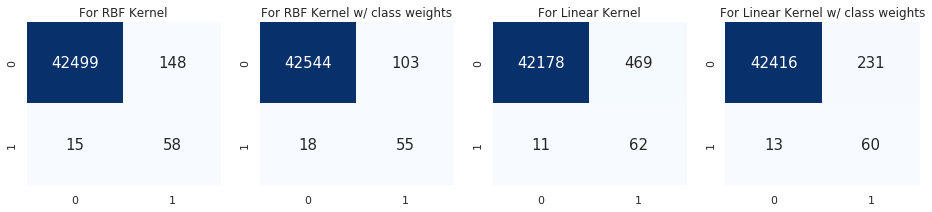

In [28]:

fig, ax = plt.subplots(1, 4, figsize=(16, 3))

svm = SVC(kernel='rbf')\
    .fit(reduced_data_std.drop(['Class'], axis=1).values, reduced_data_std.Class.values)
y_pred = svm.predict(test)
sns.heatmap(confusion_matrix(test_y, y_pred), annot=True, ax=ax[0], cmap="Blues", cbar = False, fmt='.0f', annot_kws={"fontsize":15})
bottom, top = ax[0].get_ylim()
ax[0].set_ylim(bottom + 0.5, top - 0.5)
ax[0].title.set_text(f'For RBF Kernel')

svm = SVC(kernel='rbf', class_weight={0:0.70, 1:0.30})\
    .fit(reduced_data_std.drop(['Class'], axis=1).values, reduced_data_std.Class.values)
y_pred = svm.predict(test)
sns.heatmap(confusion_matrix(test_y, y_pred), annot=True, ax=ax[1], cmap="Blues", cbar = False, fmt='.0f', annot_kws={"fontsize":15})
bottom, top = ax[1].get_ylim()
ax[1].set_ylim(bottom + 0.5, top - 0.5)
ax[1].title.set_text(f'For RBF Kernel w/ class weights')

svm = SVC(kernel='linear')\
    .fit(reduced_data_std.drop(['Class'], axis=1).values, reduced_data_std.Class.values)
y_pred = svm.predict(test)
sns.heatmap(confusion_matrix(test_y, y_pred), annot=True, ax=ax[2], cmap="Blues", cbar = False, fmt='.0f', annot_kws={"fontsize":15})
bottom, top = ax[2].get_ylim()
ax[2].set_ylim(bottom + 0.5, top - 0.5)
ax[2].title.set_text(f'For Linear Kernel')

svm = SVC(kernel='linear', class_weight={0:0.60, 1:0.40})\
    .fit(reduced_data_std.drop(['Class'], axis=1).values, reduced_data_std.Class.values)
y_pred = svm.predict(test)
sns.heatmap(confusion_matrix(test_y, y_pred), annot=True, ax=ax[3], cmap="Blues", cbar = False, fmt='.0f', annot_kws={"fontsize":15})
bottom, top = ax[3].get_ylim()
ax[3].set_ylim(bottom + 0.5, top - 0.5)
ax[3].title.set_text(f'For Linear Kernel w/ class weights')